### Advanced Lane Finding Project
    The goals / steps of this project are the following:
        Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
        Apply a distortion correction to raw images.
        Use color transforms, gradients, etc., to create a thresholded binary image.
        Apply a perspective transform to rectify binary image ("birds-eye view").
        Detect lane pixels and fit to find the lane boundary.
        Determine the curvature of the lane and vehicle position with respect to center.
        Warp the detected lane boundaries back onto the original image.
        Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.patches as patches
import globals   ### Bunch of globals to be shared across the whole module

### Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

camera_cal\calibration1.jpg could not find corners


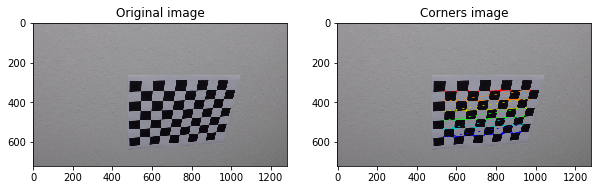

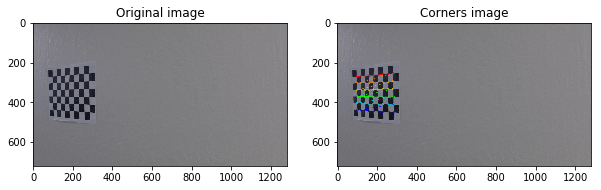

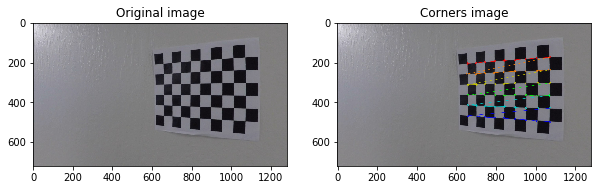

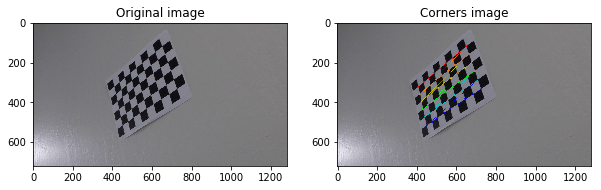

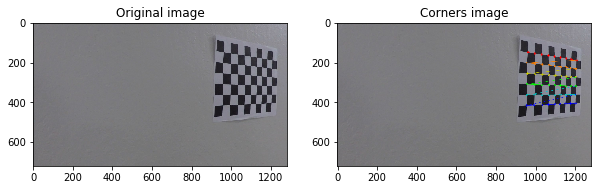

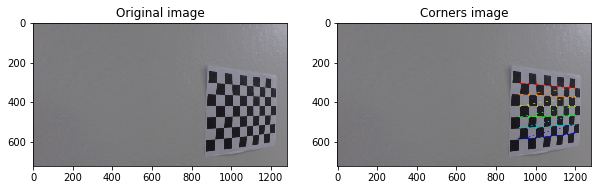

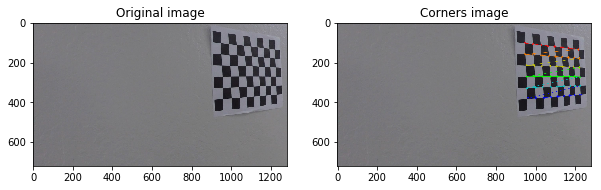

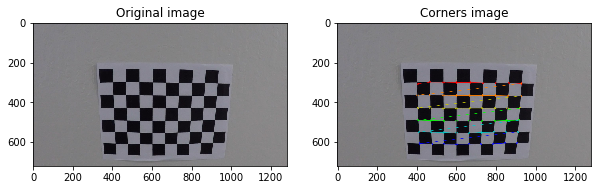

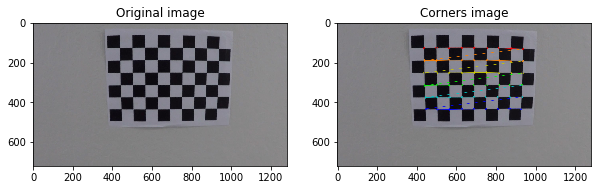

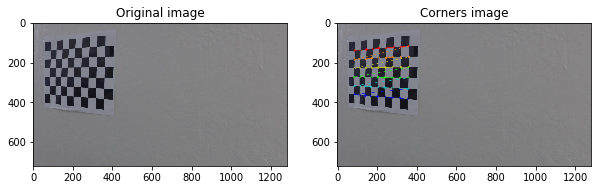

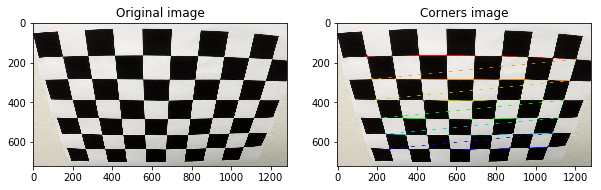

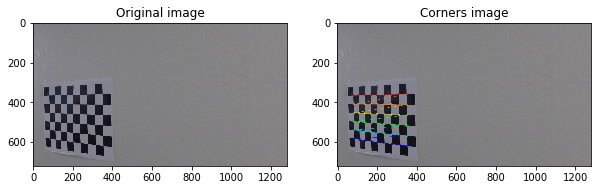

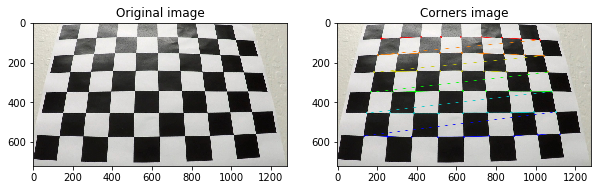

camera_cal\calibration4.jpg could not find corners
camera_cal\calibration5.jpg could not find corners


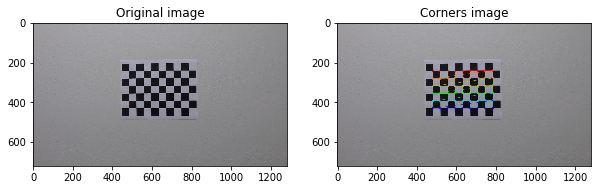

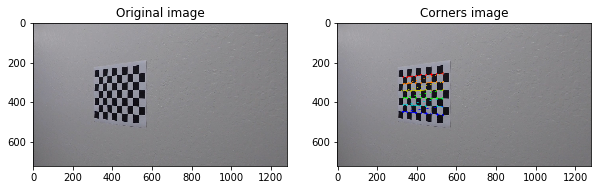

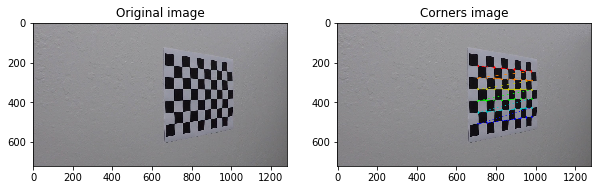

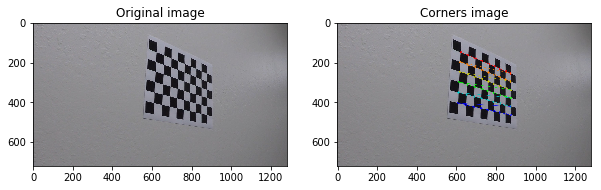

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((globals.nx*globals.ny,3), np.float32)
objp[:,:2] = np.mgrid[0:globals.nx, 0:globals.ny].T.reshape(-1,2)
#print (objp.shape)
#print (objp)

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
### Need to reinitialize - otherwise this grows
globals.objpoints = [] # 3d points in real world space
globals.imgpoints = [] # 2d points in image plane.

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    img2 = img
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  ## Because we read using cv2.imread

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (globals.nx,globals.ny), None)

    # If found, add object points, image points
    if ret == True:
        globals.objpoints.append(objp)
        globals.imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (globals.nx,globals.ny), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        #cv2.imshow('img', img)
        #cv2.waitKey(500)
        _, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
        ax1.imshow(cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB))
        ax1.set_title('Original image')
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title('Corners image')
    else:
        print ("{} could not find corners".format(fname) )

    plt.show()

ret, globals.mtx, globals.dist, rvecs, tvecs = \
cv2.calibrateCamera(globals.objpoints, globals.imgpoints, gray.shape[::-1], None, None)


### Apply a distortion correction to raw images¶

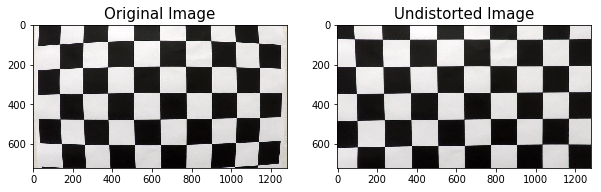

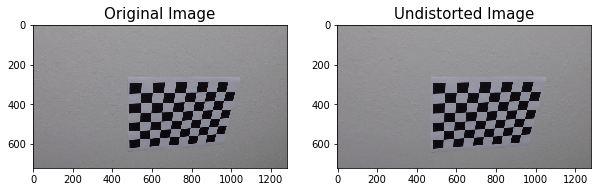

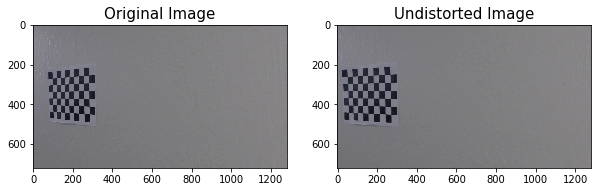

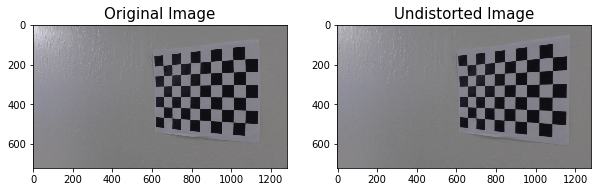

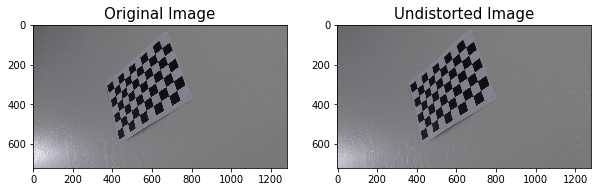

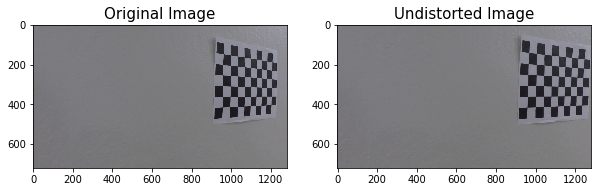

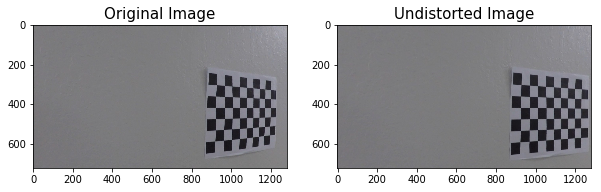

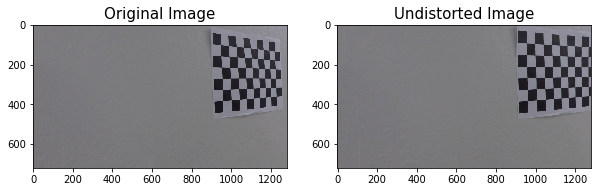

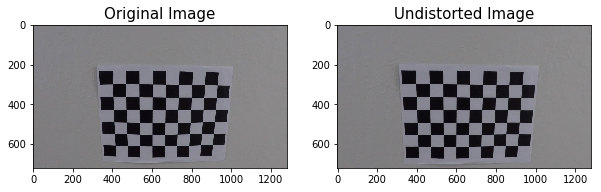

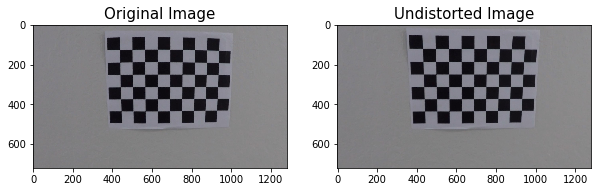

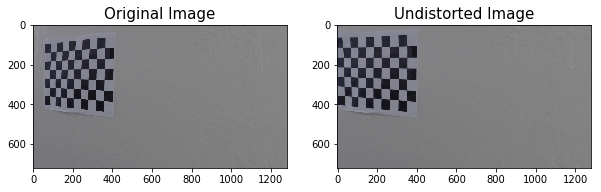

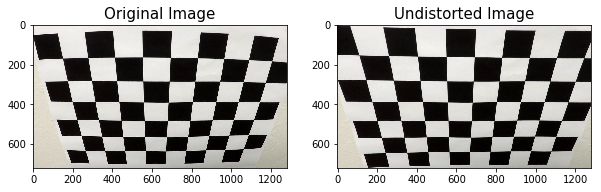

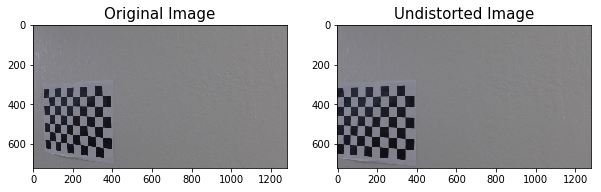

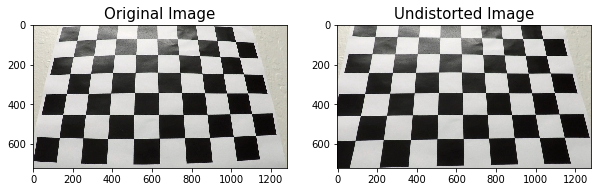

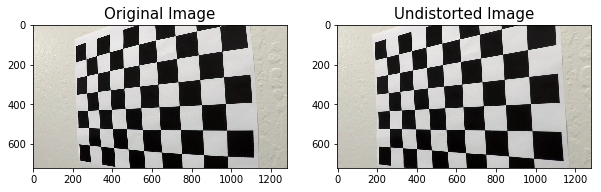

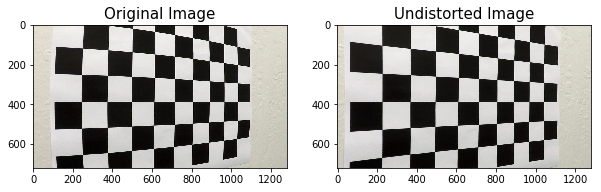

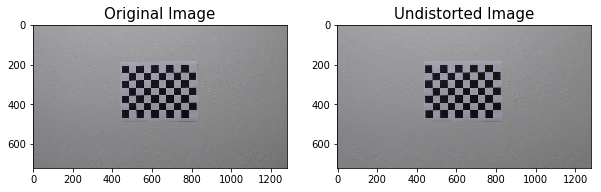

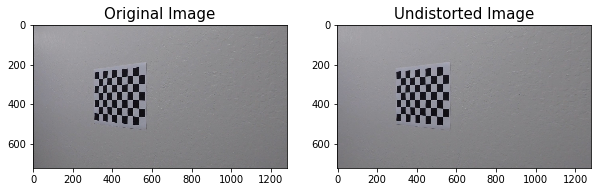

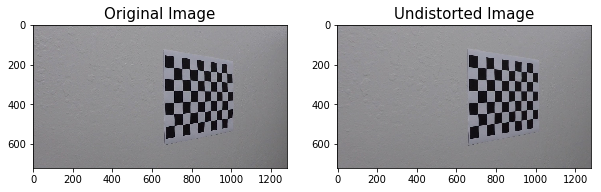

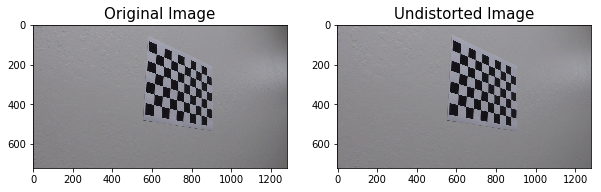

In [3]:
## Correct the distortion from 
def apply_distorted_correction(img):  # img is read as cv2.imread
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    undist = cv2.undistort(img, globals.mtx, globals.dist, None, globals.mtx)
    return undist


for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    undistorted = apply_distorted_correction(img)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.imshow(cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=15)
    ax2.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
    ax2.set_title('Undistorted Image', fontsize=15)
plt.show()

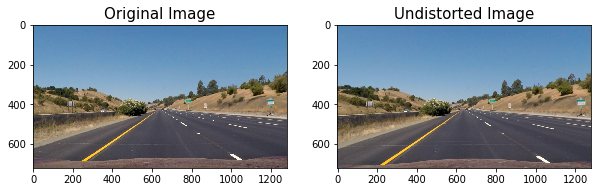

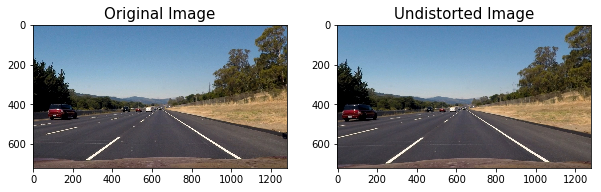

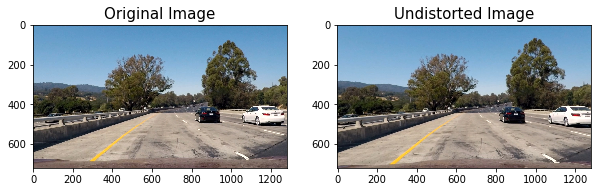

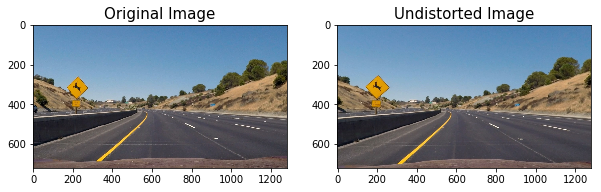

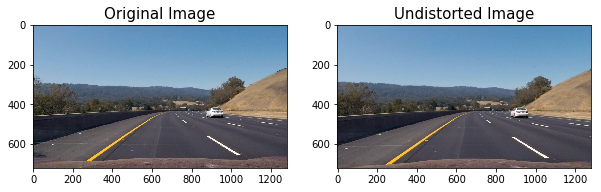

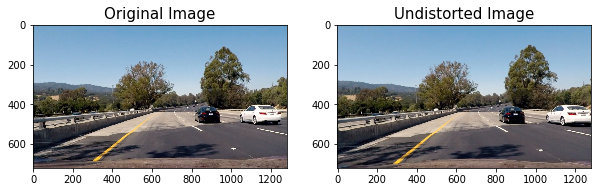

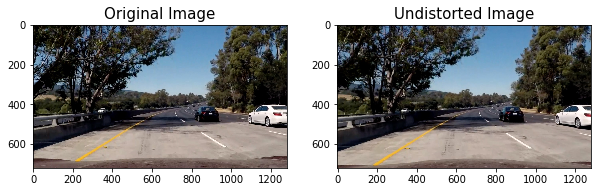

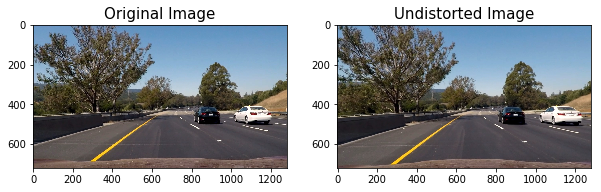

In [4]:
test_images = glob.glob('test_images/*.jpg')
for idx, fname in enumerate(test_images):
    img = cv2.imread(fname)
    undistorted = apply_distorted_correction(img)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=15)
    ax2.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
    ax2.set_title('Undistorted Image', fontsize=15)
plt.show()

### Use color transforms, gradients, etc., to create a thresholded binary image.

(-0.5, 1279.5, 719.5, -0.5)

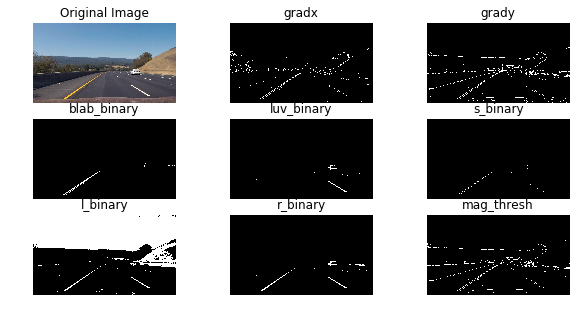

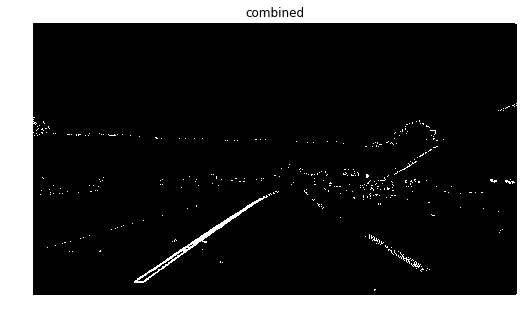

In [5]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', sobel_kernel = 5, thresh=(0,255)):  # img is read using mpimg   
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))    
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)): # img is read using mpimg    
   # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)): # img is read using mpimg
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def gray_threshold (img, gray_thresh=(0,255)):  ### img is read using mpimg
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    binary_output = np.zeros_like(gray)
    binary_output[(gray > thresh[0]) & (gray <= thresh[1])] = 1
    return binary_output

def r_threshold (img, thresh=(0, 255)):
    r_channel = img[:,:,0]
    # Threshold color channel
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= thresh[0]) & (r_channel <= thresh[1])] = 1
    return r_binary

def b_threshold (img, thresh=(0, 255)):
    b_channel = img[:,:,2]
    # Threshold color channel
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= thresh[0]) & (b_channel <= thresh[1])] = 1
    return b_binary

### 225 - 255 for white lines
def luv_threshold(img, thresh=(0,255)):
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    ch = luv[:,:,0] 
    #print  (ch[ np.nonzero(ch) ])
    luv_binary = np.zeros_like(ch)
    luv_binary[(ch >= thresh[0]) & (ch <= thresh[1])] = 1
    #luv_binary[(ch >= 0) & (ch <= 255)]
    #print  (luv_binary[ np.nonzero(luv_binary) ])
    return luv_binary

### HLS ===> H (0-179), L and S (0-255)

def s_threshold (img, thresh=(170, 255)):
    #img = np.copy(img)
    # Convert to HLS color space and separate the s channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return s_binary

def l_threshold (img, thresh=255):
    #img = np.copy(img)
    # Convert to HLS color space and separate the s channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Threshold color channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(s_channel > 20) & (l_channel >= thresh)] = 1
    return l_binary

def blab_threshold(img, thresh=(0,255)):
    blab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab) # convert RGB to floating-point format and scaled to fit the 0 to 1 range.
    blab2 = blab[:,:,2]
    blab_binary = np.zeros_like(blab2)
    blab_binary[((blab2 >= thresh[0]) & (blab2 <= thresh[1]))] = 1
    return blab_binary



### Just refactored code to apply multiple binary thresholds
def apply_binary (img):
    allgrads = {}
    allgrads ['gradx'] = abs_sobel_thresh(img, orient='x',  sobel_kernel = ksize, thresh=(30, 100))
    allgrads ['grady'] = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(30, 100))
    allgrads ['mag_binary'] = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(50, 150))
    ### Could not find any use with this threshold
    allgrads ['dir_binary'] = dir_threshold(img, sobel_kernel=ksize, thresh=(1.3, 1.8))
    allgrads ['s_binary'] = s_threshold (img, thresh=(170, 245) )
    allgrads ['l_binary'] = l_threshold (img, thresh=130 )  ### 110
    allgrads ['r_binary'] = r_threshold (img, thresh=(200, 255) )
    allgrads ['blab_binary'] = blab_threshold (img, thresh=(155 ,200) )
    allgrads ['luv_binary'] = luv_threshold (img, thresh=(220, 255) )  ## 200, 225
    combined = np.zeros_like(allgrads['gradx'])
    '''
    combined[ ((allgrads['luv_binary']==1)&(allgrads['l_binary']==1)&(allgrads['s_binary']==1))
             |((allgrads['gradx'] == 1)&(allgrads['mag_binary']==1) )
             ] = 1
    '''
    combined[ ((allgrads['luv_binary']==1)&(allgrads['s_binary']==1))
             |((allgrads['gradx'] == 1)&(allgrads['grady']==1))
             |((allgrads['blab_binary']==1))
             ] = 1
    
    allgrads ['combined'] = combined
    #print (np.nonzero(allgrads['luv_binary'])   )
    
    return allgrads

### Just refactored code to apply perspective
def apply_perspective (img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)     
    return M, Minv, warped

### This applies
# 1. birds eye perspective
# 2. Then applies all binaries
def apply_perspective_binary (img, src, dst, ksize=5): #img is read as mpimg.imread
    ## Undistort
    undist = cv2.undistort(img, globals.mtx, globals.dist, None, globals.mtx)
    '''
    (M, Minv, warped) = apply_perspective (undist, src, dst)    
    ## Apply binarie
    allgrads = apply_binary(warped)
    return M, Minv, undist, warped, allgrads['combined']
    '''
    allgrads = apply_binary(undist)
    
    (M, Minv, warped) = apply_perspective (allgrads['combined'], src, dst) 
    #print ("undist shape", undist.shape)
    _,_,p = apply_perspective(img, src, dst)
    return M, Minv, undist, p, warped

# Choose a Sobel kernel size
ksize = 5 # Choose a larger odd number to smooth gradient measurements
img = mpimg.imread('test_images/test3.jpg')

allgrads = apply_binary (img)

f, ((ax1, ax2, ax3),(ax4, ax5, ax6),(ax7,ax8,ax9)) = plt.subplots(3, 3, figsize=(10,5))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=12)
ax1.axis('off')

ax2.imshow(allgrads['gradx'], cmap='gray')
ax2.set_title('gradx', fontsize=12)
ax2.axis('off')

ax3.imshow(allgrads['grady'], cmap='gray')
ax3.set_title('grady', fontsize=12)
ax3.axis('off')

ax4.imshow(allgrads['blab_binary'], cmap='gray')
ax4.set_title('blab_binary', fontsize=12)
ax4.axis('off')

ax5.imshow(allgrads['luv_binary'], cmap='gray')
ax5.set_title('luv_binary', fontsize=12)
ax5.axis('off')

ax6.imshow(allgrads['s_binary'], cmap='gray')
ax6.set_title('s_binary', fontsize=12)
ax6.axis('off')

ax7.imshow(allgrads['l_binary'], cmap='gray')
ax7.set_title('l_binary', fontsize=12)
ax7.axis('off')

ax8.imshow(allgrads['r_binary'], cmap='gray')
ax8.set_title('r_binary', fontsize=12)
ax8.axis('off')

hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]
ax9.imshow(allgrads['mag_binary'], cmap='gray')
ax9.set_title('mag_thresh', fontsize=12)
ax9.axis('off')


f, (bx1) = plt.subplots(1, 1, figsize=(12,5))
bx1.imshow(allgrads['combined'], cmap='gray')
bx1.set_title('combined', fontsize=12)
bx1.axis('off')


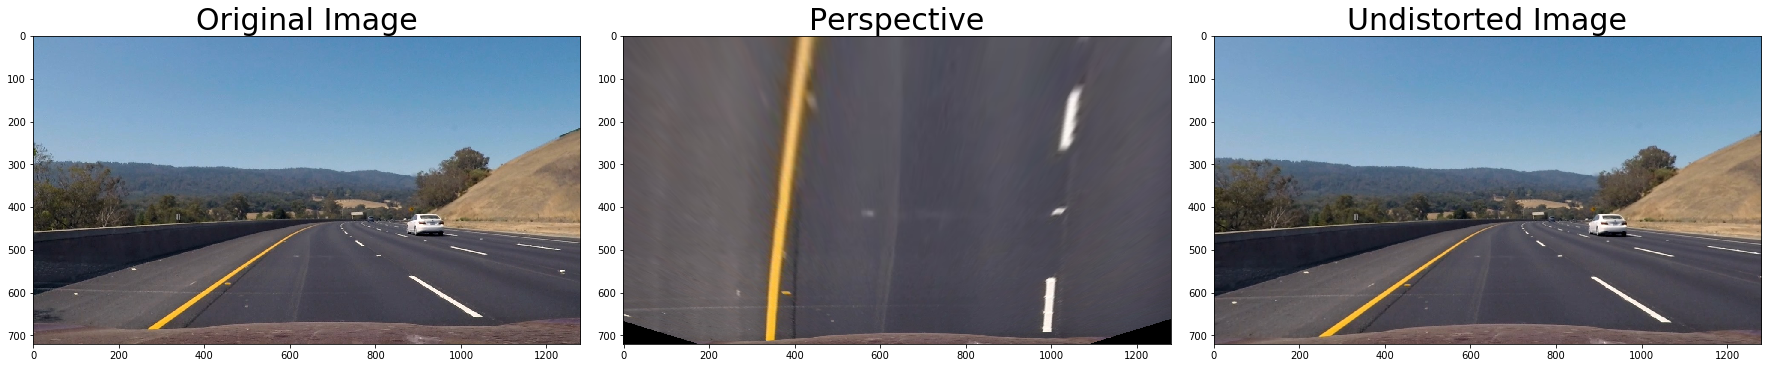

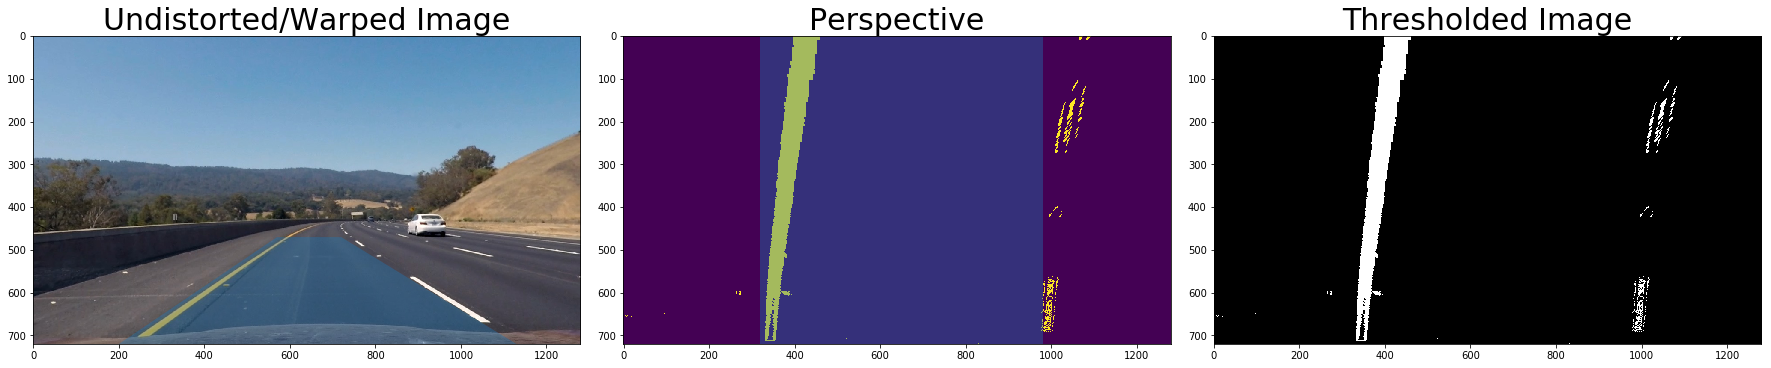

In [6]:
'''
img_size = (img.shape[1], img.shape[0])
globals.src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
globals.dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
'''

#globals.src = np.float32([[580,460], [200,720],[1130,720], [700,460]])
#globals.dst = np.float32([[340,0], [340,720],[1050,720], [1050,0]])

#print (globals.src) 
#print (globals.dst)


# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist, src, dst):  ## img is mpimp.imread
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx) 
    # Given src and dst points, calculate the perspective transform matrix
    (M, _, warped) = apply_perspective(undist, src, dst)
    return warped, M, undist

top_down, perspective_M, undist = corners_unwarp(img, globals.nx,\
                                                 globals.ny, globals.mtx, globals.dist, \
                                                 globals.src, globals.dst)



f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(top_down)
ax2.set_title('Perspective', fontsize=30)
ax3.imshow(undist)
ax3.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

_,_,undist1,warped1,combined1 = apply_perspective_binary (img, globals.src, globals.dst)


f, (ax4, ax5, ax6) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax4.imshow(undist1)
ax4.set_title('Undistorted/Warped Image', fontsize=30)
ax5.imshow(combined1)
ax5.set_title('Perspective', fontsize=30)

patches = []
polygon = Polygon(globals.src.reshape(4,2), fill=False)
patches.append(polygon)
p = PatchCollection(patches, alpha=0.4)
#p.set_array(np.array(colors))
ax4.add_collection(p)


patches = []
polygon = Polygon(globals.dst.reshape(4,2), fill=False)
patches.append(polygon)
p = PatchCollection(patches, alpha=0.4)
#p.set_array(np.array(colors))
ax5.add_collection(p)

ax6.imshow(combined1, cmap='gray')
ax6.set_title('Thresholded Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



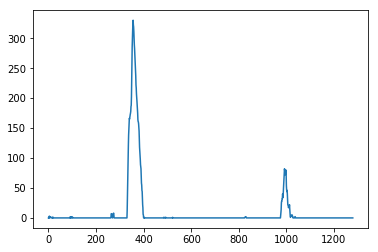

In [7]:
histogram = np.sum(combined1[combined1.shape[0]//2:,:], axis=0)
plt.plot(histogram)

### Detect lane pixels and fit to find the lane boundary.

In [8]:
def find_lane_lines(binary_warped):
    #print ("binary_wrapped")
    #print (binary_warped.shape)
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img = out_img.astype(np.uint8)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
        
    global left_fit, right_fit, left_fit_poly, right_fit_poly
    if globals.detected_line==False:
        for window in range(nwindows): # Step through the windows one by one
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 4)
            
            #print ((win_xleft_low,win_y_low),(win_xleft_high,win_y_high))
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 4) 
            #print ((win_xright_low,win_y_low),(win_xright_high,win_y_high))
            # 

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty,leftx, 2)
        right_fit = np.polyfit(righty,rightx,2)
        
        ### Save
        left_fit_poly = np.array([left_fit])
        right_fit_poly = np.array([right_fit])
       
    else: ## This code makes the next call to just calculate as we already found the fit
        #print ("in else block")
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

    if left_fit is None or right_fit is None:
        globals.detected_line = False
    else:
        globals.detected_line = False
    
    # Average poly coefficient
    '''
    print (left_fit_poly)
    print ("*****")
    print (left_fit)
    '''
    left_fit_poly = np.concatenate((left_fit_poly,[left_fit]),axis=0)#[-5:]
    #print ("*****")
    #print (left_fit_poly)
    right_fit_poly = np.concatenate((right_fit_poly,[right_fit]),axis=0)#[-5:]
    
    left_fit = np.average(left_fit_poly, axis=0)
    right_fit = np.average(right_fit_poly, axis=0)
    
    # x & y values for plotting
    #out_img[lefty, leftx] = [255,0,0]
    #out_img[righty,rightx] = [0,0,255]
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    #print (rightx, righty)
    #print ()
    
    return out_img, left_lane_inds, right_lane_inds, leftx, lefty, rightx, righty, left_fit, right_fit, nonzerox, nonzeroy


(720, 0)

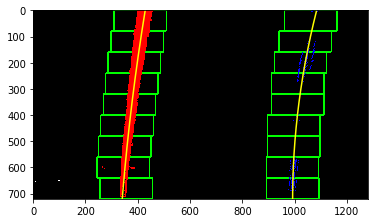

In [9]:
globals.detected_line=False
out_img, left_lane_inds, right_lane_inds, leftx, lefty, rightx, righty, \
    left_fit, right_fit, nonzerox, nonzeroy = find_lane_lines(combined1)

ploty = np.linspace(0, combined1.shape[0]-1, combined1.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
#print (out_img.shape)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


(720, 0)

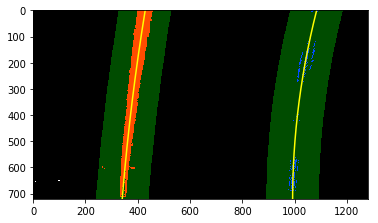

In [10]:
margin = 100
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((combined1, combined1, combined1))*255
out_img = out_img.astype(np.uint8)
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Determine the curvature of the lane and vehicle position with respect to center.

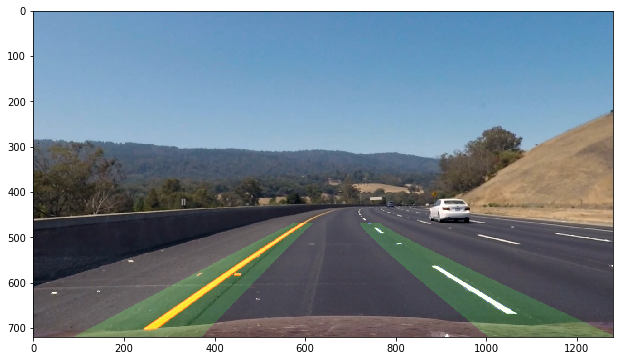

In [11]:
M = cv2.getPerspectiveTransform(globals.dst, globals.src)
img_size = (result.shape[1], result.shape[0])
unwarped = cv2.warpPerspective(result, M, img_size, flags=cv2.INTER_LINEAR)
final = cv2.addWeighted(undist, 1, unwarped,0.5,0)
plt.figure(figsize=(15,6))
plt.imshow(final)

In [12]:
def get_curvature(ploty, leftx, lefty, rightx, righty, left_fit, right_fit):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    #print (y_eval, " yeval")
    #print (left_fit[0], 'left_fit 0', left_fit[1], 'Left_fit1')
    #print (right_fit[0], 'right_fit 0', right_fit[1], 'right_fit1')
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print(left_curverad, right_curverad)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    return (left_curverad, right_curverad)

#You can assume the camera is mounted at the center of the car, such that the lane center 
#is the midpoint at the bottom of the image between the two lines you've detected. 
#The offset of the lane center from the center of the image (converted from pixels to meters) 
#is your distance from the center of the lane.

def get_center(img, ploty, left_fit, right_fit):
    ymax = np.max(ploty)
    xm_per_pix = 3.7/700 # meters per px in x-dim
    left = left_fit[0]*ymax**2 + left_fit[1]*ymax + left_fit[2]
    right = right_fit[0]*ymax**2 + right_fit[1]*ymax + right_fit[2]
    center = (left + right) / 2
    return (img.shape[1]/2 - center)*xm_per_pix

def draw_lines(combined, img, leftx, lefty, rightx, righty):
    '''
    leftx2 = leftx[::-1]
    rightx2 = rightx[::-1]
    leftx2 = leftx
    rightx2 = rightx
    
    left_fit = np.polyfit(lefty, leftx2, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx2, 2) 
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
   
    left_points = np.vstack(([left_fitx], [lefty])).T
    right_points = np.vstack(([right_fitx],[righty])).T
    all_points = np.concatenate((left_points, right_points[::-1]))
    #left_points = np.vstack(([left_fitx.T], [lefty.T])).T
    #right_points = np.vstack(([right_fitx.T], [righty.T])).T   
    cv2.polylines(img, np.int32([left_points]), False, (255, 0, 0), 20)
    cv2.polylines(img, np.int32([right_points]), False, (255, 0, 0), 20)        
    cv2.fillConvexPoly(img, np.int32([all_points]), (0, 255, 0))
    '''
    # Fit a second order polynomial to each
    # Generate x and y values for plotting
    
    '''
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2) 
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]

    left_points = np.vstack(([left_fitx.T], [lefty.T])).T
    right_points = np.vstack(([right_fitx.T], [righty.T])).T
    ### Reverse right points
    all_points = np.concatenate((left_points, right_points[::-1]))
    
    cv2.fillConvexPoly(img, np.int32([all_points]), (0, 255, 0))
    cv2.polylines(img, np.int32([left_points]), False, (255, 0, 0), 20)
    cv2.polylines(img, np.int32([right_points]), False, (255, 0, 0), 20)        
    '''
    # Fit, Recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, combined.shape[0]-1, combined.shape[0])  

    # Fit first
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2) 
    # Compute
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    #Recast
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(img, np.int_([pts]), (0,255, 0))
    cv2.polylines(img, np.int32([pts_left]), False, (255, 0, 0), 20)
    cv2.polylines(img, np.int32([pts_right]), False, (255, 0, 0), 20)        

    #print (all_points)
    #print (all_points.shape)
    #print (left_points.shape)
    
    return img

In [13]:
def pipeline_process(img):

    M, Minv, undist, warped, combined = apply_perspective_binary(img, globals.src, globals.dst)
    global left_fit, right_fit, left_fit_poly, right_fit_poly
    
    
    #left_fit, right_fit, left_fit_poly, right_fit_poly = None, None, None, None
  
    ### !!!!!! warped -> combined
    out_img, left_lane_inds, right_lane_inds, leftx, lefty, \
        rightx, righty, left_fit, right_fit, nonzerox, nonzeroy =\
        find_lane_lines(combined)
    
    #### !!!!! warped -> combined
    #### !!!!! warped -> undist
    drawwarped = draw_lines(combined, np.zeros_like(warped), leftx, lefty, rightx, righty)
    #print ("drawwarped shape", drawwarped.shape)
    #print (warped.shape, combined.shape, undist.shape)
    
    Minv = cv2.getPerspectiveTransform(globals.dst, globals.src)    
    img_size = (img.shape[1], img.shape[0])
    unwarped = cv2.warpPerspective(drawwarped, Minv, img_size, flags=cv2.INTER_LINEAR)        

    output = cv2.addWeighted(undist, 1, unwarped, 0.3, 0.0)
    
    left_curverad, right_curverad = get_curvature(lefty, leftx, lefty, rightx, righty, \
                                                    left_fit, right_fit)
    curvature = min([left_curverad, right_curverad])
    text = "Curvature of Radius: {:.2f} m".format(curvature)
    cv2.putText(output, text, (50,80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    
    text1 = "Left curve: {:.2f} m".format(left_curverad)
    cv2.putText(output, text1, (50,200), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    text1 = "Right curve: {:.2f} m ".format(right_curverad)
    cv2.putText(output, text1, (50,260), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    
    pos = get_center(img, ploty, left_fit, right_fit)
    if pos < 0:
        text = "Vehicle is {:.2f} m on left".format(-pos)
    else:
        text = "Vehicle is {:.2f} m on right".format(pos)
    cv2.putText(output, text, (50,140), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    
    return output

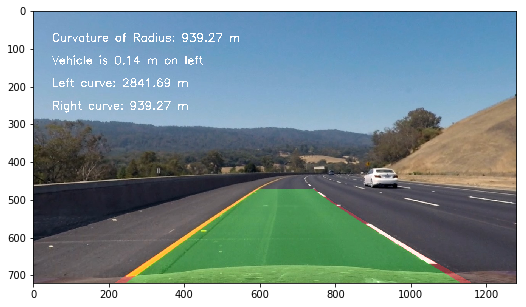

In [14]:
global left_fit, right_fit, left_fit_poly, right_fit_poly
#left_fit, right_fit, left_fit_poly, right_fit_poly = None, None, None, None
left_fit, right_fit = None, None
globals.detected_line=False
#left_fit, right_fit=None,None
output = pipeline_process(img)
plt.figure(figsize=(15,5))
plt.imshow(output)

In [15]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
project_output = 'project_video_output.mp4'
#clip1 = VideoFileClip('project_video.mp4').subclip(20,25)
clip1 = VideoFileClip('project_video.mp4')
global left_fit, right_fit, left_fit_poly, right_fit_poly
#left_fit, right_fit, left_fit_poly, right_fit_poly = None, None, None, None
left_fit, right_fit = None, None
globals.detected_line=False
project_clip = clip1.fl_image(pipeline_process)
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [13:55<00:00,  1.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 13min 59s
